# IMPORT DATA and PLOT

       obs       oil       inf    growth        pa          e         pb
0  1973M01  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000
1  1973M02 -0.910593 -0.651378 -0.808943  0.192845  -2.800062  -1.251061
2  1973M03 -1.037341 -0.464413  0.419297 -0.790535  -2.969075  -2.473440
3  1973M04  0.238282 -0.557528  0.396233 -1.929574  -6.481253  -5.062312
4  1973M05 -0.715433 -0.972816  0.184617 -6.806141 -12.416007 -10.776334


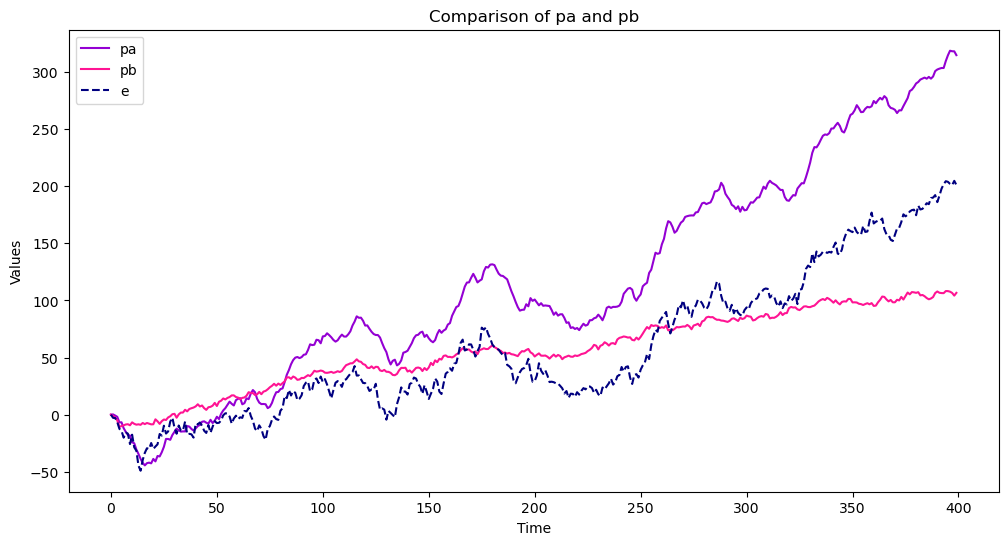

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/Contucci_Marco.csv')
print(data.head())

# Plot of the 2 series
plt.figure(figsize=(12, 6))
plt.plot(data['pa'], label='pa', color='darkviolet')
plt.plot(data['pb'], label='pb', color='deeppink')
plt.plot(data['e'], label='e', color='navy',linestyle='--')
plt.title('Comparison of pa and pb')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# ADF

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_pa = adfuller(data['pa'])
adf_pb = adfuller(data['pb'])
adf_e = adfuller(data['e'])

print('ADF Statistic for pA:', adf_pa[0], 'p-value:', adf_pa[1])
print('ADF Statistic for pB:', adf_pb[0], 'p-value:', adf_pb[1])
print('ADF Statistic for eAB:', adf_e[0], 'p-value:', adf_e[1])

ADF Statistic for pA: 0.5550961879781255 p-value: 0.986454911861702
ADF Statistic for pB: -1.8045116876263145 p-value: 0.3782240777455919
ADF Statistic for eAB: 0.49200151288931626 p-value: 0.9846279504810067


# COINTEGRATION TEST

In [28]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_data = data[['pa', 'pb', 'e']]

# Johansen cointegration test
johansen_test = coint_johansen(coint_data, det_order = 0, k_ar_diff = 1)

# Trace statistics
trace_stats = johansen_test.lr1
crit_values = johansen_test.cvt
max_eig_stats = johansen_test.lr2
critical_values_max_eig = johansen_test.cvm

# Print the results
print("Eigenvalues:\n", johansen_test.eig)
print("Trace Statistics:\n", trace_stats)
print("Critical Values Trace (90%, 95%, 99%):\n", crit_values)
print("Max-Eigen Statistic:\n", max_eig_stats)
print("Critical Values Max-Eig (90%, 95%, 99%):\n", critical_values_max_eig)

Eigenvalues:
 [0.41849657 0.016192   0.0042997 ]
Trace Statistics:
 [223.98321671   8.2121284    1.71496913]
Critical Values Trace (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-Eigen Statistic:
 [215.77108831   6.49715927   1.71496913]
Critical Values Max-Eig (90%, 95%, 99%):
 [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


# VECM model

In [54]:
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_order

# Order selecting
order_results = select_order(coint_data, maxlags = 10, deterministic = "ci")
print(order_results.summary())

# fitting the VECM model
vecm_model = VECM(coint_data, coint_rank = 1, k_ar_diff = 1)  # coint_rank=1 b
vecm_fit = vecm_model.fit()
print(vecm_fit.summary())

# Getting the coefficients of the error correction term
ecm_coefficients = vecm_fit.alpha

# Summary of the ECM coefficients
print("ECM coefficients:"
    "\nPA (pa):", ecm_coefficients[0][0],
    "\nEAB (e):", ecm_coefficients[1][0],
    "\nPB (pb):", ecm_coefficients[2][0])

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       5.327*      5.480*      205.8*      5.387*
1        5.338       5.583       208.1       5.435
2        5.359       5.696       212.6       5.493
3        5.373       5.801       215.5       5.542
4        5.389       5.909       219.1       5.595
5        5.413       6.024       224.3       5.655
6        5.443       6.146       231.3       5.722
7        5.463       6.258       235.9       5.778
8        5.485       6.371       241.2       5.836
9        5.502       6.480       245.4       5.890
10       5.505       6.575       246.3       5.929
--------------------------------------------------
Det. terms outside the coint. relation & lagged endog. parameters for equation pa
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

# RESIDUAL DIAGNOSTIC

In [53]:
residuals = vecm_fit.resid
residual_diagnostic = vecm_fit.test_whiteness(nlags = 1, signif = 0.05).summary()
print(residual_diagnostic) #BOIADEH

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 1 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.3481            nan     NAN -3
----------------------------------------
